Download the data

In [1]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip
!ls

--2020-11-09 20:33:04--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.226.49.83, 13.226.49.80, 13.226.49.39, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.226.49.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  15.8MB/s    in 0.2s    

2020-11-09 20:33:05 (15.8 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italia

In [27]:
%matplotlib inline


Classifying Names with a Character-Level RNN
*********************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

We will be building and training a basic character-level RNN to classify
words. A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step. We take the final prediction
to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling:

::

    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch


**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  http://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-  `The Unreasonable Effectiveness of Recurrent Neural
   Networks <http://karpathy.github.io/2015/05/21/rnn-effectiveness/>`__
   shows a bunch of real life examples
-  `Understanding LSTM
   Networks <http://colah.github.io/posts/2015-08-Understanding-LSTMs/>`__
   is about LSTMs specifically but also informative about RNNs in
   general

Preparing the Data
==================

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.

Included in the ``data/names`` directory are 18 text files named as
"[Language].txt". Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We'll end up with a dictionary of lists of names per language,
``{language: [names ...]}``. The generic variables "category" and "line"
(for language and name in our case) are used for later extensibility.



In [28]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import random

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string
import math

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
train_data = {}
validation_data = {}
test_data = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    random.shuffle(lines)
    train_data[category] = lines[0:int(math.floor(0.7*len(lines)))]
    validation_data[category] = lines[int(math.floor(0.7*len(lines)))+1:int(math.floor(0.85*len(lines)))]
    test_data[category] = lines[int(math.floor(0.85*len(lines)))+1:]
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Irish.txt', 'data/names/Czech.txt', 'data/names/Portuguese.txt', 'data/names/German.txt', 'data/names/Vietnamese.txt', 'data/names/Polish.txt', 'data/names/Chinese.txt', 'data/names/French.txt', 'data/names/Russian.txt', 'data/names/Dutch.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/English.txt', 'data/names/Italian.txt', 'data/names/Japanese.txt', 'data/names/Arabic.txt', 'data/names/Korean.txt', 'data/names/Scottish.txt']
Slusarski


Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.




In [29]:
print(category_lines['Italian'][:5])

['Vestri', 'Anselmetti', 'Acciai', 'Bello', 'Capello']


Turning Names into Tensors
--------------------------

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.




In [30]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


Creating the Network
====================

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.

This RNN module (mostly copied from `the PyTorch for Torch users
tutorial <http://pytorch.org/tutorials/beginner/former_torchies/
nn_tutorial.html#example-2-recurrent-net>`__)
is just 2 linear layers which operate on an input and hidden state, with
a LogSoftmax layer after the output.

.. figure:: https://i.imgur.com/Z2xbySO.png
   :alt:





In [53]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)      

In [54]:
import torch.nn as nn
from torch.autograd import Variable
class RNN_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_GRU, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.GRUCell(input_size+hidden_size , hidden_size)
        
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined) 
        output = self.i2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn_gru = RNN_GRU(n_letters, n_hidden, n_categories)

In [55]:
import torch.nn as nn
from torch.autograd import Variable

class RNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_LSTM, self).__init__()
        self.hidden_size = hidden_size
        
        self.i2h = nn.LSTMCell(input_size+hidden_size+hidden_size, hidden_size)    
        self.i2o = nn.Linear( hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden,hidden_state):

        combined = torch.cat((input, hidden,hidden_state), 1)

        hidden,hidden_state = self.i2h(combined)

        output = self.i2o(hidden)

        output = self.softmax(output)

        return output, hidden,hidden_state

    def initHidden(self):
        return torch.zeros(1, self.hidden_size),torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn_lstm = RNN_LSTM(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).




In [10]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
pre-computing batches of Tensors.




In [34]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8316, -2.8505, -2.9477, -2.8780, -2.9831, -2.8465, -2.8195, -2.8405,
         -2.8505, -2.8072, -2.8351, -2.9989, -2.8934, -2.8283, -2.8855, -2.9585,
         -2.9960, -3.0178]], grad_fn=<LogSoftmaxBackward>)


As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




Training
========
Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:




In [46]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i


We will also want a quick way to get a training example (a name and its
language):




In [47]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(train_data[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Czech / line = Quasninsky
category = Russian / line = Mikhalenkov
category = Arabic / line = Seif
category = Japanese / line = Matsushina
category = Polish / line = Sniegowski
category = Arabic / line = Safar
category = German / line = Maus
category = Japanese / line = Komon
category = English / line = Myatt
category = Korean / line = Sun


Training the Network
--------------------

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [56]:
criterion = nn.NLLLoss()

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss




In [57]:
optimizer = torch.optim.Adam(rnn.parameters())

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    # reset gradient
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)

    # compute gradient by backpropagation
    loss.backward()

    # update parameters
    optimizer.step()

    return output, loss.item()

In [58]:
criterion_gru = nn.NLLLoss()

In [59]:
optimizer_gru = torch.optim.Adam(rnn_gru.parameters())

def train_gru(category_tensor, line_tensor):
    hidden = rnn_gru.initHidden()

    # reset gradient
    rnn_gru.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn_gru(line_tensor[i], hidden)
    loss = criterion_gru(output, category_tensor)

    # compute gradient by backpropagation
    loss.backward()

    # update parameters
    optimizer_gru.step()

    return output, loss.item()

In [60]:
criterion_lstm = nn.NLLLoss()

In [61]:
optimizer_lstm = torch.optim.Adam(rnn_lstm.parameters())

def train_lstm(category_tensor, line_tensor):
    hidden,hidden_state = rnn_lstm.initHidden()

    # reset gradient
    rnn_lstm.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden,hidden_state = rnn_lstm(line_tensor[i], hidden,hidden_state)
    loss = criterion_lstm(output, category_tensor)

    # compute gradient by backpropagation
    loss.backward()

    # update parameters
    optimizer_lstm.step()

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




In [62]:
import time
import math

n_iters = 80000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
train_loss = 0
all_train_losses = []
all_validation_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    return output

def eval_dataset(dataset):
    loss = 0
    n_instances = 0
    confusion = torch.zeros(n_categories, n_categories)
    for category in all_categories:
        category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            line_tensor = Variable(lineToTensor(line))
            output = evaluate(line_tensor)
            loss += criterion(output, category_tensor)
            guess, guess_i = categoryFromOutput(output)
            category_i = all_categories.index(category)
            confusion[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    return loss.item() / n_instances, confusion
  
print('\nIter \tTrain% \tTime \t\tTrain_loss \tExample')
start = time.time()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    train_loss += loss

    # Print iter number, train loss average, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d \t%d%% \t(%s) \t%.4f \t\t%s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), train_loss / plot_every, line, guess, correct))

    # Add current train loss average to list of losses
    if iter % plot_every == 0:
        all_train_losses.append(train_loss / plot_every)
        train_loss = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss, _ = eval_dataset(validation_data)

        # save model with best validation loss
        if len(all_validation_losses) == 0 or average_validation_loss < min(all_validation_losses):
            torch.save(rnn, 'char_rnn_classification_model.pt')
        all_validation_losses.append(average_validation_loss)



Iter 	Train% 	Time 		Train_loss 	Example
5000 	6% 	(0m 20s) 	1.8754 		Brunet / English ✓
10000 	12% 	(0m 44s) 	1.6719 		Sneijer / Czech ✗ (Dutch)
15000 	18% 	(1m 7s) 	1.4577 		Delgado / Spanish ✓
20000 	25% 	(1m 30s) 	1.4514 		Araujo / Portuguese ✓
25000 	31% 	(1m 54s) 	1.3634 		Akrivopoulos / Greek ✓
30000 	37% 	(2m 17s) 	1.3595 		Krantz / German ✗ (Dutch)
35000 	43% 	(2m 40s) 	1.2758 		Tuck / Czech ✗ (English)
40000 	50% 	(3m 3s) 	1.2674 		Chun / Irish ✗ (Korean)
45000 	56% 	(3m 27s) 	1.2130 		Mclean / Scottish ✓
50000 	62% 	(3m 50s) 	1.2877 		Pinho / Japanese ✗ (Portuguese)
55000 	68% 	(4m 13s) 	1.1888 		Shin / Korean ✓
60000 	75% 	(4m 37s) 	1.2361 		Nascimbene / French ✗ (Italian)
65000 	81% 	(5m 1s) 	1.2137 		Winograd / English ✗ (Polish)
70000 	87% 	(5m 25s) 	1.3115 		Freitas / Greek ✗ (Portuguese)
75000 	93% 	(5m 48s) 	1.1339 		Morcos / Portuguese ✗ (Arabic)
80000 	100% 	(6m 11s) 	1.1892 		Brabbery / French ✗ (Czech)


In [63]:
import time
import math

n_iters = 80000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
train_loss_gru = 0
all_train_losses_gru = []
all_validation_losses_gru = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Just return an output given a line
def evaluate_gru(line_tensor):
    hidden = rnn_gru.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn_gru(line_tensor[i], hidden)
    return output

def eval_dataset_gru(dataset):
    loss = 0
    n_instances = 0
    confusion = torch.zeros(n_categories, n_categories)
    for category in all_categories:
        category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            line_tensor = Variable(lineToTensor(line))
            output = evaluate_gru(line_tensor)
            loss += criterion_gru(output, category_tensor)
            guess, guess_i = categoryFromOutput(output)
            category_i = all_categories.index(category)
            confusion[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    return loss.item() / n_instances, confusion
  
print('\nIter \tTrain% \tTime \t\tTrain_loss \tExample')
start = time.time()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_gru(category_tensor, line_tensor)
    train_loss_gru += loss

    # Print iter number, train loss average, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d \t%d%% \t(%s) \t%.4f \t\t%s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), train_loss_gru / plot_every, line, guess, correct))

    # Add current train loss average to list of losses
    if iter % plot_every == 0:
        all_train_losses_gru.append(train_loss_gru / plot_every)
        train_loss_gru = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss_gru, _ = eval_dataset_gru(validation_data)

        # save model with best validation loss
        if len(all_validation_losses_gru) == 0 or average_validation_loss_gru < min(all_validation_losses_gru):
            torch.save(rnn_gru, 'char_rnn_classification_model_gru.pt')
        all_validation_losses_gru.append(average_validation_loss_gru)


Iter 	Train% 	Time 		Train_loss 	Example
5000 	6% 	(0m 53s) 	1.6128 		Cihak / Polish ✗ (Czech)
10000 	12% 	(1m 54s) 	1.2989 		Youn / Korean ✓
15000 	18% 	(2m 58s) 	1.0906 		Tselios / Greek ✓
20000 	25% 	(3m 57s) 	0.8775 		Han / Chinese ✗ (Vietnamese)
25000 	31% 	(4m 57s) 	0.6893 		Southern / German ✗ (English)
30000 	37% 	(5m 57s) 	0.6567 		Kavanagh / Irish ✓
35000 	43% 	(6m 56s) 	0.6179 		Jasso / Spanish ✓
40000 	50% 	(7m 56s) 	0.5239 		Diep / Vietnamese ✓
45000 	56% 	(8m 56s) 	0.5165 		Pletcher / German ✓
50000 	62% 	(9m 55s) 	0.4460 		Deeb / Arabic ✓
55000 	68% 	(10m 55s) 	0.3676 		Luong / Vietnamese ✓
60000 	75% 	(11m 55s) 	0.3970 		Than / Vietnamese ✓
65000 	81% 	(12m 57s) 	0.3335 		Bui / Vietnamese ✓
70000 	87% 	(13m 57s) 	0.3973 		Son / Korean ✓
75000 	93% 	(14m 56s) 	0.3770 		Solos / Spanish ✓
80000 	100% 	(15m 55s) 	0.3386 		Totolos / Greek ✓


In [64]:
import time
import math

n_iters = 80000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
train_loss_lstm = 0
all_train_losses_lstm = []
all_validation_losses_lstm = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Just return an output given a line
def evaluate_lstm(line_tensor):
    hidden,hidden_state = rnn_lstm.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden,hidden_state = rnn_lstm(line_tensor[i], hidden,hidden_state)
    return output

def eval_dataset_lstm(dataset):
    loss = 0
    n_instances = 0
    confusion = torch.zeros(n_categories, n_categories)
    for category in all_categories:
        category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            line_tensor = Variable(lineToTensor(line))
            output = evaluate_lstm(line_tensor)
            loss += criterion_lstm(output, category_tensor)
            guess, guess_i = categoryFromOutput(output)
            category_i = all_categories.index(category)
            confusion[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    return loss.item() / n_instances, confusion
  
print('\nIter \tTrain% \tTime \t\tTrain_loss \tExample')
start = time.time()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_lstm(category_tensor, line_tensor)
    train_loss_lstm += loss

    # Print iter number, train loss average, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d \t%d%% \t(%s) \t%.4f \t\t%s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), train_loss_lstm / plot_every, line, guess, correct))

    # Add current train loss average to list of losses
    if iter % plot_every == 0:
        all_train_losses_lstm.append(train_loss_lstm / plot_every)
        train_loss_lstm = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss_lstm, _ = eval_dataset_lstm(validation_data)

        # save model with best validation loss
        if len(all_validation_losses_lstm) == 0 or average_validation_loss_lstm < min(all_validation_losses_lstm):
            torch.save(rnn_lstm, 'char_rnn_classification_model_lstm.pt')
        all_validation_losses_lstm.append(average_validation_loss_lstm)


Iter 	Train% 	Time 		Train_loss 	Example
5000 	6% 	(1m 4s) 	1.7906 		Qiu / Chinese ✓
10000 	12% 	(2m 15s) 	1.3587 		Patselas / Greek ✓
15000 	18% 	(3m 26s) 	1.0470 		Kerr / Scottish ✓
20000 	25% 	(4m 38s) 	0.9624 		Veselitsky / Russian ✓
25000 	31% 	(5m 51s) 	0.7672 		Rapallino / Italian ✓
30000 	37% 	(7m 5s) 	0.6429 		Guerin / French ✓
35000 	43% 	(8m 17s) 	0.6673 		Desjardins / French ✓
40000 	50% 	(9m 29s) 	0.6139 		Lucassen / Dutch ✓
45000 	56% 	(10m 41s) 	0.5882 		Zitka / Czech ✓
50000 	62% 	(11m 52s) 	0.4643 		Tuma / Arabic ✓
55000 	68% 	(13m 5s) 	0.4527 		White / Scottish ✓
60000 	75% 	(14m 16s) 	0.4754 		Cameron / Scottish ✓
65000 	81% 	(15m 28s) 	0.5008 		D'cruz / Spanish ✗ (Portuguese)
70000 	87% 	(16m 43s) 	0.4260 		Kasamatsu / Japanese ✓
75000 	93% 	(17m 53s) 	0.5053 		Jagoda / Polish ✓
80000 	100% 	(19m 5s) 	0.4427 		Nisbet / French ✗ (English)


Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:




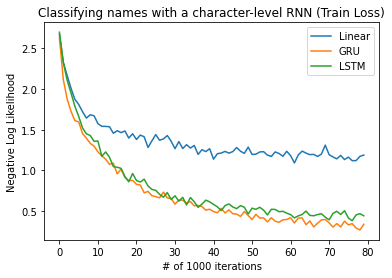

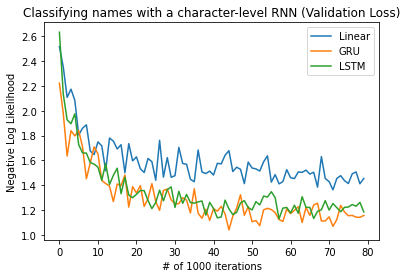

In [65]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_train_losses,label='Linear')
plt.plot(all_train_losses_gru,label='GRU')
plt.plot(all_train_losses_lstm,label='LSTM')
plt.title('Classifying names with a character-level RNN (Train Loss)')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('# of 1000 iterations')
plt.legend( loc='upper right')


plt.figure()
plt.plot(all_validation_losses,label='Linear')
plt.plot(all_validation_losses_gru,label='GRU')
plt.plot(all_validation_losses_lstm,label='LSTM')
plt.title('Classifying names with a character-level RNN (Validation Loss)')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('# of 1000 iterations')
plt.legend( loc='upper right')


Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.




Average test loss: 1.342841448683772


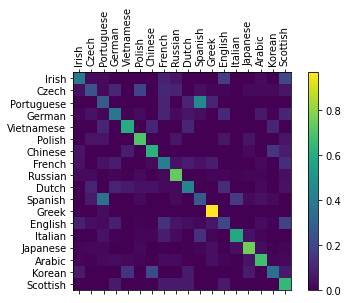

In [69]:
# evaluate on test set and display confusion matrix
rnn = torch.load('char_rnn_classification_model.pt')
average_test_loss, confusion = eval_dataset(test_data)
print('Average test loss: ' + str(average_test_loss))

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

Average test loss_GRU: 1.0135805154792152


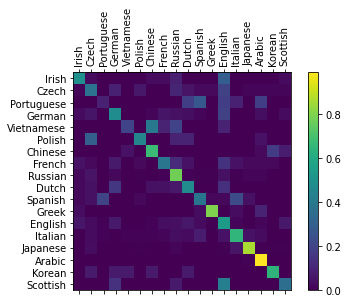

In [70]:
# evaluate on test set and display confusion matrix
rnn_gru = torch.load('char_rnn_classification_model_gru.pt')
average_test_loss_gru, confusion_gru = eval_dataset_gru(test_data)
print('Average test loss_GRU: ' + str(average_test_loss_gru))

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax_gru = ax.matshow(confusion_gru.numpy())
fig.colorbar(cax_gru)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

Average test loss_LSTM: 1.1485858066842303


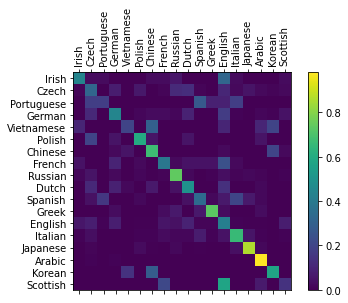

In [71]:
# evaluate on test set and display confusion matrix
rnn_lstm = torch.load('char_rnn_classification_model_lstm.pt')
average_test_loss_lstm, confusion_lstm = eval_dataset_lstm(test_data)
print('Average test loss_LSTM: ' + str(average_test_loss_lstm))

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax_lstm = ax.matshow(confusion_lstm.numpy())
fig.colorbar(cax_lstm)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).




Running on User Input
---------------------




In [72]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.19) Russian
(-2.14) Czech
(-3.42) English

> Jackson
(-0.76) Russian
(-0.92) Scottish
(-2.56) English

> Satoshi
(-1.02) Polish
(-1.29) Japanese
(-1.49) Arabic


as we can see in the plots,training loss of linear hidden unit will be larger at the end of training compared to LSTM and GRU. this behaviour was expected since linear unit is less expressive than GRU and LSTM and we expected more complicated models with ability to utilize gates in memory outperform linear hidden unit given enough of training. same trend is seen for validation and test loss.

on the other hand we can see that LSTM and GRU units perform similarly but GRU is slightly better. 

we know that GRU has fewer parameters(LSTM is more complicated) and needs less data for training and optimization .

that's the reason why its performance is most of the time better or as good as LSTM  in training and validation and testing.



The final versions of the scripts `in the Practical PyTorch
repo <https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification>`__
split the above code into a few files:

-  ``data.py`` (loads files)
-  ``model.py`` (defines the RNN)
-  ``train.py`` (runs training)
-  ``predict.py`` (runs ``predict()`` with command line arguments)
-  ``server.py`` (serve prediction as a JSON API with bottle.py)

Run ``train.py`` to train and save the network.

Run ``predict.py`` with a name to view predictions:

::

    $ python predict.py Hazaki
    (-0.42) Japanese
    (-1.39) Polish
    (-3.51) Czech

Run ``server.py`` and visit http://localhost:5533/Yourname to get JSON
output of predictions.




Exercises
=========

-  Try with a different dataset of line -> category, for example:

   -  Any word -> language
   -  First name -> gender
   -  Character name -> writer
   -  Page title -> blog or subreddit

-  Get better results with a bigger and/or better shaped network

   -  Add more linear layers
   -  Try the ``nn.LSTM`` and ``nn.GRU`` layers
   -  Combine multiple of these RNNs as a higher level network


